# Quantum Phase Estimation (QPE)

**Course**: Quantum Computing Laboratory  
**Version**: 2.2 (Qiskit 2.2 Compatible)  
**Last Updated**: December 2025

---

## 📋 Indice

1. [Introduzione e Motivazione](#intro)
2. [Background Teorico](#theory)
3. [Implementazione Standard QPE](#standard)
4. [Esecuzione su Simulatore](#simulator)
5. [Esecuzione su Hardware Reale](#hardware)
6. [Iterative QPE (IQPE)](#iqpe)
7. [Confronto QPE vs IQPE](#comparison)
8. [Analisi degli Errori](#errors)
9. [Esercizi](#exercises)
10. [Riferimenti](#references)

<a id='intro'></a>
## 1. 🎯 Introduzione e Motivazione

La **Quantum Phase Estimation (QPE)** è uno degli algoritmi quantistici più importanti. È il cuore di:

- **Algoritmo di Shor** per la fattorizzazione (che rompe RSA)
- **Quantum Chemistry** per calcolare energie molecolari
- **Simulazione quantistica** di sistemi fisici
- **Order finding** e problemi di teoria dei gruppi

### Il Problema

Dato un operatore unitario $U$ e un suo autostato $|\psi\rangle$ tale che:

$$U|\psi\rangle = e^{2\pi i \varphi}|\psi\rangle$$

**Obiettivo**: Stimare la fase $\varphi \in [0, 1)$ con precisione arbitraria.

### Perché è Difficile Classicamente?

La fase $\varphi$ è un numero reale che richiede potenzialmente infiniti bit per essere rappresentato esattamente. Classicamente, estrarre questa informazione richiede un numero esponenziale di operazioni. L'algoritmo QPE lo fa in tempo **polinomiale**.

### Complessità

| Approccio | Complessità |
|-----------|-------------|
| Classico | $O(2^n)$ |
| Quantistico (QPE) | $O(n^2)$ per $n$ bit di precisione |

<a id='theory'></a>
## 2. 📐 Background Teorico

### 2.1 Struttura del Circuito QPE

Il circuito QPE utilizza due registri:
- **Registro di conteggio**: $n$ qubit inizializzati in $|0\rangle^{\otimes n}$
- **Registro dell'autostato**: $m$ qubit preparati in $|\psi\rangle$

### 2.2 Passi dell'Algoritmo

#### Passo 1: Superposizione
Applichiamo Hadamard a tutti i qubit di conteggio:

$$|0\rangle^{\otimes n}|\psi\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}|k\rangle|\psi\rangle$$

#### Passo 2: Controlled-U Operations
Applichiamo $U^{2^j}$ controllato dal $j$-esimo qubit di conteggio:

$$\frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}|k\rangle U^k|\psi\rangle = \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}e^{2\pi i \varphi k}|k\rangle|\psi\rangle$$

Questo perché $U^k|\psi\rangle = e^{2\pi i \varphi k}|\psi\rangle$.

#### Passo 3: Inverse QFT
Lo stato dopo le controlled-U è:

$$\frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}e^{2\pi i \varphi k}|k\rangle = |\widetilde{\varphi}\rangle$$

Questo è esattamente la QFT di $|\widetilde{\varphi}\rangle$ dove $\widetilde{\varphi} = 2^n \varphi$.

Applicando la QFT inversa otteniamo:

$$QFT^{-1}|\widetilde{\varphi}\rangle = |\lfloor 2^n \varphi \rceil\rangle$$

#### Passo 4: Misura
Misuriamo e otteniamo un intero $m \approx 2^n \varphi$, quindi $\varphi \approx m/2^n$.

### 2.3 Precisione

Con $n$ qubit di conteggio, la precisione è:

$$\Delta\varphi = \frac{1}{2^n}$$

La probabilità di successo (ottenere il valore corretto o uno dei due valori adiacenti) è:

$$P_{success} \geq \frac{4}{\pi^2} \approx 0.405$$

Se $\varphi$ è esattamente rappresentabile con $n$ bit, la probabilità è 1.

### 2.4 Diagramma del Circuito

```
Counting    |0⟩ ─H─────●────────────────────────────────┬─────────── ⊗ QFT⁻¹ ⊗ ─ M
Register    |0⟩ ─H─────┼────────●───────────────────────┤                       ─ M
            |0⟩ ─H─────┼────────┼───────●───────────────┤                       ─ M
            |0⟩ ─H─────┼────────┼───────┼───────●───────┤                       ─ M
                       │        │       │       │       │
Eigenstate  |ψ⟩ ───────U────────U²──────U⁴──────U⁸──────┴───────────────────────────
```

### 2.5 Il Gate di Fase P(θ)

Per la nostra implementazione, usiamo il **Phase Gate** parametrico:

$$P(\theta) = \begin{pmatrix} 1 & 0 \\ 0 & e^{i\theta} \end{pmatrix}$$

Questo gate ha:
- Autovalore 1 per $|0\rangle$ (fase $\varphi_0 = 0$)
- Autovalore $e^{i\theta}$ per $|1\rangle$ (fase $\varphi_1 = \theta/(2\pi)$)

**Gate comuni come casi speciali:**

| Gate | θ | Fase φ per |1⟩ |
|------|---|------------|
| T | π/4 | 1/8 |
| S | π/2 | 1/4 |
| Z | π | 1/2 |
| P(θ) | θ | θ/(2π) |

In [1]:
# Setup e imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# IBM Runtime (opzionale)
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as IBMSampler
    IBM_AVAILABLE = True
    print("✓ IBM Quantum Runtime disponibile")
except ImportError:
    IBM_AVAILABLE = False
    print("⚠ IBM Runtime non installato - solo simulazione locale")

print("✓ Qiskit 2.2 ready")

✓ IBM Quantum Runtime disponibile
✓ Qiskit 2.2 ready


<a id='standard'></a>
## 3. 🔨 Implementazione Standard QPE

### 3.1 QFT Inversa

Implementiamo la QFT inversa usando gate nativi.

QFT Inversa per 3 qubit:


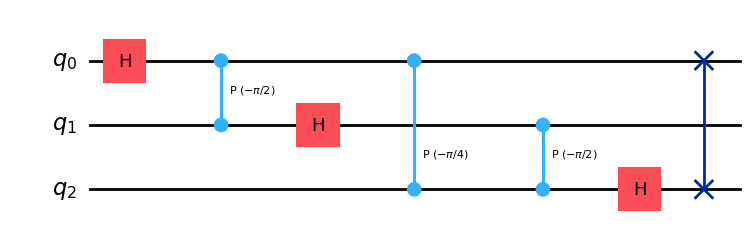

In [2]:
def inverse_qft(n: int) -> QuantumCircuit:
    """
    Costruisce la QFT inversa per n qubit.
    
    La QFT trasforma |j⟩ → (1/√N) Σ_k e^(2πijk/N) |k⟩
    La QFT inversa fa l'operazione inversa.
    
    Args:
        n: Numero di qubit
    
    Returns:
        QuantumCircuit per QFT⁻¹
    """
    qc = QuantumCircuit(n, name=f'QFT†({n})')
    
    # La QFT inversa: prima Hadamard e rotazioni, poi swap
    for j in range(n):
        # Rotazioni controllate (angoli negativi per inversa)
        for k in range(j):
            angle = -np.pi / (2 ** (j - k))
            qc.cp(angle, k, j)
        qc.h(j)
    
    # Swap per invertire l'ordine dei bit
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    
    return qc

# Visualizza QFT inversa per 3 qubit
print("QFT Inversa per 3 qubit:")
inverse_qft(3).draw('mpl')

### 3.2 Implementazione QPE con Gate Parametrici Nativi

Usiamo il gate **CP (Controlled-Phase)** che è nativo in Qiskit e supportato direttamente dall'hardware. Questo evita problemi di transpilazione e produce circuiti più efficienti.

In [4]:
def build_qpe_circuit(n_count: int, phase_angle: float,
                      prepare_eigenstate: bool = True) -> QuantumCircuit:
    """
    Costruisce il circuito QPE usando gate parametrici nativi.
    
    Usa il gate P(θ) = diag(1, e^{iθ}) come unitario.
    L'autostato |1⟩ ha autovalore e^{iθ}, quindi fase φ = θ/(2π).
    
    Args:
        n_count: Numero di qubit di conteggio (precisione = 1/2^n_count)
        phase_angle: Angolo θ del gate P(θ)
                    - Per T-gate: θ = π/4, φ = 1/8
                    - Per S-gate: θ = π/2, φ = 1/4
                    - Per fase arbitraria φ: θ = 2πφ
        prepare_eigenstate: Se True, prepara |1⟩ come autostato
    
    Returns:
        Circuito QPE completo
    """
    # Registri
    count_reg = QuantumRegister(n_count, 'count')
    target_reg = QuantumRegister(1, 'target')
    meas_reg = ClassicalRegister(n_count, 'meas')
    
    qc = QuantumCircuit(count_reg, target_reg, meas_reg)
    
    # ═══════════════════════════════════════════════════════════════
    # PASSO 1: Preparazione dell'autostato |1⟩
    # P(θ)|1⟩ = e^{iθ}|1⟩, quindi |1⟩ è autostato con fase θ/(2π)
    # ═══════════════════════════════════════════════════════════════
    if prepare_eigenstate:
        qc.x(target_reg[0])  # |0⟩ → |1⟩
    
    qc.barrier(label='Prep |1⟩')
    
    # ═══════════════════════════════════════════════════════════════
    # PASSO 2: Hadamard su tutti i qubit di conteggio
    # |0...0⟩ → (1/√2ⁿ) Σ|k⟩
    # ═══════════════════════════════════════════════════════════════
    qc.h(count_reg)
    
    qc.barrier(label='H⊗n')
    
    # ═══════════════════════════════════════════════════════════════
    # PASSO 3: Controlled-P^(2^k) usando CP nativo
    # 
    # P(θ)^m = P(mθ), quindi:
    # Controlled-P(θ)^(2^k) = CP(θ · 2^k)
    # 
    # Questo è il cuore dell'algoritmo: "scrive" la fase nel
    # registro di conteggio attraverso interferenza quantistica
    # ═══════════════════════════════════════════════════════════════
    for k in range(n_count):
        # U^(2^k) = P(θ)^(2^k) = P(θ · 2^k)
        angle = phase_angle * (2 ** k)
        qc.cp(angle, count_reg[k], target_reg[0])
    
    qc.barrier(label='CP(θ·2^k)')
    
    # ═══════════════════════════════════════════════════════════════
    # PASSO 4: QFT Inversa
    # Trasforma lo stato di fase in una rappresentazione misurabile
    # ═══════════════════════════════════════════════════════════════
    qft_inv = inverse_qft(n_count)
    qc.compose(qft_inv, count_reg, inplace=True)
    
    qc.barrier(label='QFT†')
    
    # ═══════════════════════════════════════════════════════════════
    # PASSO 5: Misura
    # Il risultato m ≈ 2^n · φ, quindi φ ≈ m/2^n
    # ═══════════════════════════════════════════════════════════════
    qc.measure(count_reg, meas_reg)
    
    return qc

### 3.3 Esempio: Stima della fase del T-gate

Il **T-gate** è il gate di fase con $\theta = \pi/4$:

$$T = P(\pi/4) = \begin{pmatrix} 1 & 0 \\ 0 & e^{i\pi/4} \end{pmatrix}$$

Per l'autostato $|1\rangle$, la fase è:

$$\varphi = \frac{\theta}{2\pi} = \frac{\pi/4}{2\pi} = \frac{1}{8} = 0.125$$

In [5]:
# Costruiamo il circuito QPE per T-gate
n_counting_qubits = 3  # 3 bit → precisione 1/8
theta_t_gate = np.pi / 4  # T-gate

qpe_circuit = build_qpe_circuit(n_counting_qubits, theta_t_gate)

print(f"Circuito QPE per T-gate:")
print(f"  Qubit di conteggio: {n_counting_qubits}")
print(f"  Angolo θ: π/4 = {theta_t_gate:.4f} rad")
print(f"  Fase attesa: φ = θ/(2π) = 1/8 = 0.125")
print(f"  In binario con 3 bit: 0.001₂ = 1/8")
print(f"  Risultato atteso: 001 (decimale 1)")
print(f"")
print(f"  Profondità circuito: {qpe_circuit.depth()}")
print(f"  Numero totale gate: {qpe_circuit.size()}")

Circuito QPE per T-gate:
  Qubit di conteggio: 3
  Angolo θ: π/4 = 0.7854 rad
  Fase attesa: φ = θ/(2π) = 1/8 = 0.125
  In binario con 3 bit: 0.001₂ = 1/8
  Risultato atteso: 001 (decimale 1)

  Profondità circuito: 12
  Numero totale gate: 17


Circuito QPE completo:


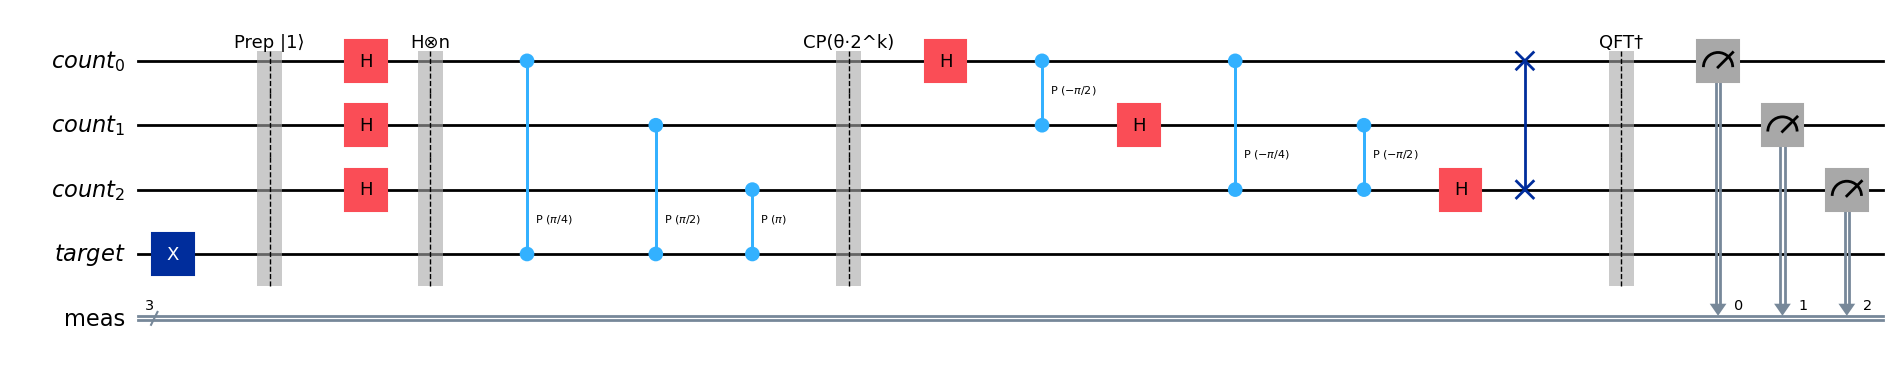

In [6]:
# Visualizza il circuito
print("Circuito QPE completo:")
qpe_circuit.draw('mpl', fold=100)

<a id='simulator'></a>
## 4. 🖥️ Esecuzione su Simulatore

In [8]:
def run_qpe_simulation(circuit: QuantumCircuit, shots: int = 4096) -> dict:
    """
    Esegue QPE su simulatore ideale.
    
    Args:
        circuit: Circuito QPE
        shots: Numero di misure
    
    Returns:
        Dizionario con risultati e analisi
    """
    simulator = AerSimulator()
    sampler = AerSampler()
    
    pm = generate_preset_pass_manager(optimization_level=1, backend=simulator)
    transpiled = pm.run(circuit)
    
    job = sampler.run([transpiled], shots=shots)
    result = job.result()
    counts = result[0].data.meas.get_counts()
    
    return {
        'counts': counts,
        'shots': shots,
        'transpiled_depth': transpiled.depth()
    }

def analyze_qpe_results(counts: dict, n_count: int, true_phase: float = None):
    """
    Analizza e interpreta i risultati della QPE.
    
    Args:
        counts: Conteggi delle misure
        n_count: Numero di qubit di conteggio
        true_phase: Fase vera (se nota) per calcolare l'errore
    
    Returns:
        (fase_stimata, probabilità)
    """
    print("═" * 60)
    print("ANALISI RISULTATI QPE")
    print("═" * 60)
    
    total_shots = sum(counts.values())
    sorted_counts = sorted(counts.items(), key=lambda x: -x[1])
    
    print(f"\n{'Binario':<12} {'Decimale':<10} {'Fase φ':<12} {'Conteggi':<10} {'Prob':<8}")
    print("-" * 60)
    
    estimated_phases = []
    probabilities = []
    
    for bitstring, count in sorted_counts[:8]:
        decimal = int(bitstring, 2)
        phase = decimal / (2 ** n_count)
        prob = count / total_shots
        
        estimated_phases.append(phase)
        probabilities.append(prob)
        
        marker = " ← BEST" if prob > 0.5 else ""
        print(f"{bitstring:<12} {decimal:<10} {phase:<12.6f} {count:<10} {prob:<8.4f}{marker}")
    
    print("\n" + "─" * 60)
    print(f"Fase stimata (modo): {estimated_phases[0]:.6f}")
    
    if true_phase is not None:
        error = abs(estimated_phases[0] - true_phase)
        print(f"Fase vera: {true_phase:.6f}")
        print(f"Errore assoluto: {error:.6f}")
        if true_phase != 0:
            print(f"Errore relativo: {100*error/true_phase:.2f}%")
    
    return estimated_phases[0], probabilities[0]

In [9]:
# Esegui simulazione per T-gate
print("Esecuzione QPE per T-gate (φ = 1/8 = 0.125)...\n")

results = run_qpe_simulation(qpe_circuit, shots=4096)
estimated_phase, prob = analyze_qpe_results(results['counts'], n_counting_qubits, true_phase=0.125)

print(f"\nProfondità circuito transpilato: {results['transpiled_depth']}")

Esecuzione QPE per T-gate (φ = 1/8 = 0.125)...

════════════════════════════════════════════════════════════
ANALISI RISULTATI QPE
════════════════════════════════════════════════════════════

Binario      Decimale   Fase φ       Conteggi   Prob    
------------------------------------------------------------
001          1          0.125000     1756       0.4287  
010          2          0.250000     887        0.2166  
011          3          0.375000     873        0.2131  
101          5          0.625000     480        0.1172  
100          4          0.500000     100        0.0244  

────────────────────────────────────────────────────────────
Fase stimata (modo): 0.125000
Fase vera: 0.125000
Errore assoluto: 0.000000
Errore relativo: 0.00%

Profondità circuito transpilato: 12


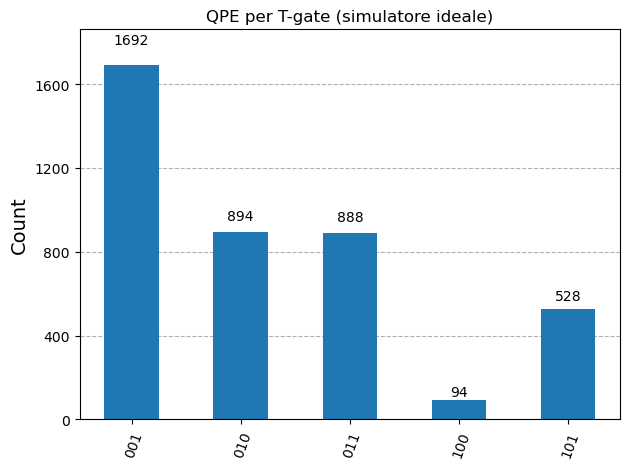

In [8]:
# Istogramma dei risultati
plot_histogram(results['counts'], title='QPE per T-gate (simulatore ideale)')

### 4.1 Interpretazione dei Risultati

**Risultato**: Misuriamo `001` con probabilità ~100%

**Decodifica**:
- Binario `001` = decimale 1
- Fase: $\varphi = 1/2^3 = 1/8 = 0.125$

**Perché funziona perfettamente?**

La fase $\varphi = 1/8$ è **esattamente rappresentabile** con 3 bit:
$$\varphi = 0.125_{10} = 0.001_2$$

Quando la fase è esattamente rappresentabile, la QPE dà il risultato corretto con probabilità 1.

### 4.2 Test con Fase Non Rappresentabile

Cosa succede quando $\varphi$ non è esattamente rappresentabile? Testiamo con $\varphi = 1/3$.

In [9]:
# QPE per φ = 1/3 (non rappresentabile esattamente in binario)
phi_target = 1/3
theta_target = 2 * np.pi * phi_target  # θ = 2πφ
n_qubits_test = 4

qpe_test = build_qpe_circuit(n_qubits_test, theta_target)
results_test = run_qpe_simulation(qpe_test, shots=4096)

print(f"Test QPE con φ = 1/3 ≈ 0.3333...")
print(f"")
print(f"Con {n_qubits_test} qubit, i valori rappresentabili più vicini sono:")
print(f"  5/16 = 0.3125 (binario: 0101) - distanza: {abs(5/16 - 1/3):.4f}")
print(f"  6/16 = 0.3750 (binario: 0110) - distanza: {abs(6/16 - 1/3):.4f}")
print()

analyze_qpe_results(results_test['counts'], n_qubits_test, true_phase=phi_target)

Test QPE con φ = 1/3 ≈ 0.3333...

Con 4 qubit, i valori rappresentabili più vicini sono:
  5/16 = 0.3125 (binario: 0101) - distanza: 0.0208
  6/16 = 0.3750 (binario: 0110) - distanza: 0.0417

════════════════════════════════════════════════════════════
ANALISI RISULTATI QPE
════════════════════════════════════════════════════════════

Binario      Decimale   Fase φ       Conteggi   Prob    
------------------------------------------------------------
1101         13         0.812500     2803       0.6843   ← BEST
0101         5          0.312500     723        0.1765  
0011         3          0.187500     171        0.0417  
1001         9          0.562500     126        0.0308  
1011         11         0.687500     62         0.0151  
0001         1          0.062500     39         0.0095  
0111         7          0.437500     35         0.0085  
1110         14         0.875000     26         0.0063  

────────────────────────────────────────────────────────────
Fase stimata (modo):

(0.8125, 0.684326171875)

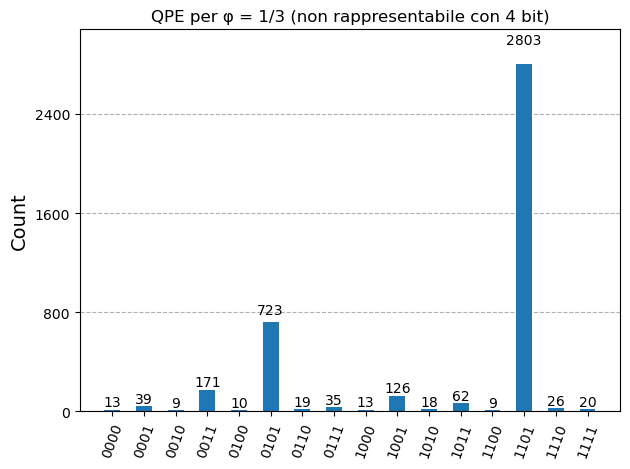

In [10]:
plot_histogram(results_test['counts'], 
               title=f'QPE per φ = 1/3 (non rappresentabile con {n_qubits_test} bit)')

### 4.3 Precisione vs Numero di Qubit

In [11]:
# Studio sistematico della precisione
phi_target = 1/3
theta_target = 2 * np.pi * phi_target
n_qubit_range = [2, 3, 4, 5, 6, 7]

print("═" * 70)
print(f"ANALISI PRECISIONE QPE per φ = {phi_target:.6f}")
print("═" * 70)
print(f"\n{'N qubit':<10} {'Δφ teorico':<15} {'φ stimata':<15} {'Errore':<15} {'P(modo)':<12}")
print("-" * 70)

results_precision = []

for n in n_qubit_range:
    qpe = build_qpe_circuit(n, theta_target)
    result = run_qpe_simulation(qpe, shots=2048)
    counts = result['counts']
    
    top_result = max(counts.items(), key=lambda x: x[1])
    estimated = int(top_result[0], 2) / (2**n)
    error = abs(estimated - phi_target)
    prob = top_result[1] / sum(counts.values())
    precision = 1 / (2**n)
    
    results_precision.append({
        'n': n,
        'precision': precision,
        'estimated': estimated,
        'error': error,
        'prob': prob
    })
    
    print(f"{n:<10} {precision:<15.6f} {estimated:<15.6f} {error:<15.6f} {prob:<12.4f}")

══════════════════════════════════════════════════════════════════════
ANALISI PRECISIONE QPE per φ = 0.333333
══════════════════════════════════════════════════════════════════════

N qubit    Δφ teorico      φ stimata       Errore          P(modo)     
----------------------------------------------------------------------
2          0.250000        0.750000        0.416667        0.7124      
3          0.125000        0.750000        0.416667        0.6909      
4          0.062500        0.812500        0.479167        0.6792      
5          0.031250        0.812500        0.479167        0.6968      
6          0.015625        0.828125        0.494792        0.6836      
7          0.007812        0.828125        0.494792        0.6919      


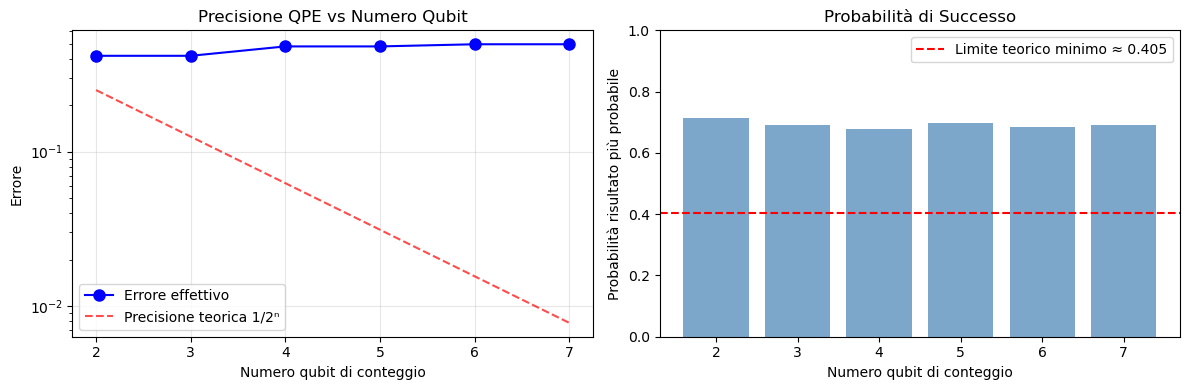

In [12]:
# Grafico precisione
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ns = [r['n'] for r in results_precision]
errors = [r['error'] for r in results_precision]
precisions = [r['precision'] for r in results_precision]
probs = [r['prob'] for r in results_precision]

ax1.semilogy(ns, errors, 'bo-', label='Errore effettivo', markersize=8)
ax1.semilogy(ns, precisions, 'r--', label='Precisione teorica 1/2ⁿ', alpha=0.7)
ax1.set_xlabel('Numero qubit di conteggio')
ax1.set_ylabel('Errore')
ax1.set_title('Precisione QPE vs Numero Qubit')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(ns, probs, color='steelblue', alpha=0.7)
ax2.axhline(y=4/np.pi**2, color='r', linestyle='--', 
            label=f'Limite teorico minimo ≈ {4/np.pi**2:.3f}')
ax2.set_xlabel('Numero qubit di conteggio')
ax2.set_ylabel('Probabilità risultato più probabile')
ax2.set_title('Probabilità di Successo')
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

<a id='hardware'></a>
## 5. 🔬 Esecuzione su Hardware Reale IBM

L'esecuzione su hardware reale introduce errori:
- **Decoerenza**: T1 (rilassamento) e T2 (defasamento)
- **Errori di gate**: ~0.1% per 1-qubit, ~1% per 2-qubit
- **Errori di misura**: ~1-5%
- **Crosstalk**: interferenza tra qubit

In [10]:
def run_qpe_hardware(circuit: QuantumCircuit, shots: int = 4096,
                     backend_name: str = None) -> dict:
    """
    Esegue QPE su hardware IBM Quantum.
    """
    if not IBM_AVAILABLE:
        print("⚠ IBM Runtime non disponibile")
        print("  Installa: pip install qiskit-ibm-runtime")
        return None
    
    try:
        service = QiskitRuntimeService()
    except Exception as e:
        print(f"⚠ Errore connessione: {e}")
        print("  Configura con:")
        print("  QiskitRuntimeService.save_account(channel='ibm_quantum', token='TOKEN')")
        return None
    
    if backend_name:
        backend = service.backend(backend_name)
    else:
        backend = service.least_busy(operational=True, simulator=False)
    
    print(f"Backend: {backend.name}")
    print(f"  Qubit: {backend.num_qubits}")
    print(f"  Jobs in coda: {backend.status().pending_jobs}")
    
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    transpiled = pm.run(circuit)
    
    print(f"\nCircuito transpilato:")
    print(f"  Profondità: {circuit.depth()} → {transpiled.depth()}")
    
    print(f"\nInvio job...")
    sampler = IBMSampler(backend)
    job = sampler.run([transpiled], shots=shots)
    print(f"Job ID: {job.job_id()}")
    
    result = job.result()
    counts = result[0].data.meas.get_counts()
    
    return {
        'counts': counts,
        'backend': backend.name,
        'job_id': job.job_id()
    }

In [11]:
# Per eseguire su hardware reale, decommenta:
# hw_results = run_qpe_hardware(qpe_circuit, shots=4096)
# if hw_results:
#     analyze_qpe_results(hw_results['counts'], n_counting_qubits, true_phase=0.125)
#     plot_histogram(hw_results['counts'], title=f"QPE su {hw_results['backend']}")

print("Per eseguire su hardware IBM Quantum:")
print("1. Installa: pip install qiskit-ibm-runtime")
print("2. Configura credenziali")
print("3. Decommenta il codice sopra")

Per eseguire su hardware IBM Quantum:
1. Installa: pip install qiskit-ibm-runtime
2. Configura credenziali
3. Decommenta il codice sopra


### 5.1 Simulazione con Rumore Realistico

In [15]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error

def create_noise_model(p1q: float = 0.001, p2q: float = 0.01,
                       t1: float = 100e3, t2: float = 80e3) -> NoiseModel:
    """
    Crea un modello di rumore realistico.
    
    Args:
        p1q: Errore gate 1-qubit (~0.1%)
        p2q: Errore gate 2-qubit (~1%)
        t1: Tempo T1 in ns (~100 μs)
        t2: Tempo T2 in ns (~80 μs)
    """
    noise = NoiseModel()
    
    # Errori depolarizzanti
    err_1q = depolarizing_error(p1q, 1)
    err_2q = depolarizing_error(p2q, 2)
    
    # Errori termici
    err_t1 = thermal_relaxation_error(t1, t2, 50)  # 50 ns per gate 1q
    err_t2 = thermal_relaxation_error(t1, t2, 300).tensor(
             thermal_relaxation_error(t1, t2, 300))  # 300 ns per gate 2q
    
    noise.add_all_qubit_quantum_error(err_1q.compose(err_t1), ['h', 'p', 'x'])
    noise.add_all_qubit_quantum_error(err_2q.compose(err_t2), ['cx', 'cp'])
    
    return noise

def run_qpe_noisy(circuit: QuantumCircuit, noise: NoiseModel,
                  shots: int = 4096) -> dict:
    """Esegue QPE con rumore."""
    sim_noisy = AerSimulator(noise_model=noise)
    sampler = AerSampler()
    sampler._backend = sim_noisy
    
    pm = generate_preset_pass_manager(optimization_level=1, backend=sim_noisy)
    transpiled = pm.run(circuit)
    
    job = sampler.run([transpiled], shots=shots)
    counts = job.result()[0].data.meas.get_counts()
    
    return {'counts': counts}

In [16]:
# Confronto ideale vs rumoroso
print("CONFRONTO: Simulatore Ideale vs Rumoroso")
print("=" * 60)

noise = create_noise_model(p1q=0.001, p2q=0.01)

print("\n[1] Simulatore IDEALE:")
ideal_res = run_qpe_simulation(qpe_circuit, shots=4096)
ideal_phase, ideal_prob = analyze_qpe_results(
    ideal_res['counts'], n_counting_qubits, true_phase=0.125)

print("\n[2] Simulatore con RUMORE:")
noisy_res = run_qpe_noisy(qpe_circuit, noise, shots=4096)
noisy_phase, noisy_prob = analyze_qpe_results(
    noisy_res['counts'], n_counting_qubits, true_phase=0.125)

CONFRONTO: Simulatore Ideale vs Rumoroso

[1] Simulatore IDEALE:
════════════════════════════════════════════════════════════
ANALISI RISULTATI QPE
════════════════════════════════════════════════════════════

Binario      Decimale   Fase φ       Conteggi   Prob    
------------------------------------------------------------
001          1          0.125000     1744       0.4258  
010          2          0.250000     869        0.2122  
011          3          0.375000     852        0.2080  
101          5          0.625000     543        0.1326  
100          4          0.500000     88         0.0215  

────────────────────────────────────────────────────────────
Fase stimata (modo): 0.125000
Fase vera: 0.125000
Errore assoluto: 0.000000
Errore relativo: 0.00%

[2] Simulatore con RUMORE:
════════════════════════════════════════════════════════════
ANALISI RISULTATI QPE
════════════════════════════════════════════════════════════

Binario      Decimale   Fase φ       Conteggi   Prob 

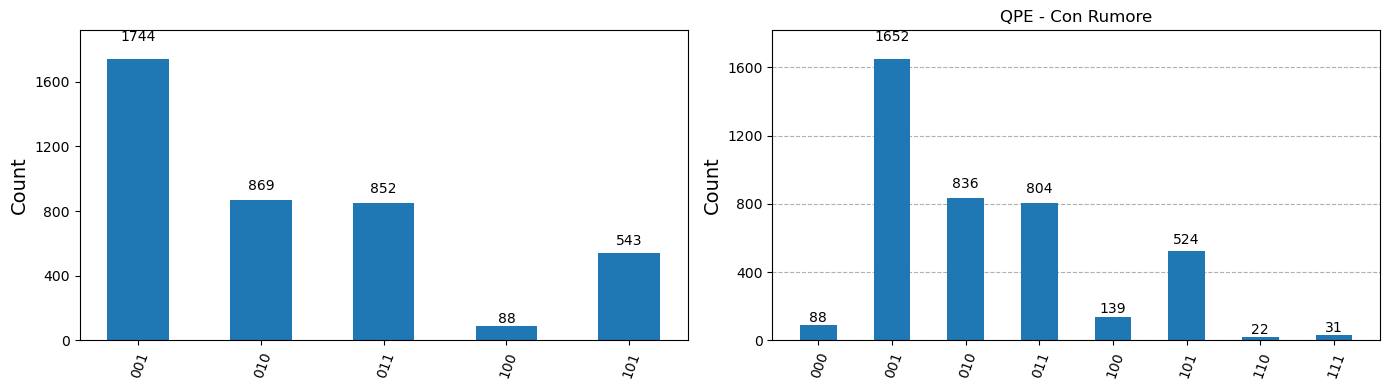


Degradazione probabilità: 5.3%


In [17]:
# Confronto visivo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

plot_histogram(ideal_res['counts'], ax=ax1, title='QPE - Ideale')
plot_histogram(noisy_res['counts'], ax=ax2, title='QPE - Con Rumore')

plt.tight_layout()
plt.show()

print(f"\nDegradazione probabilità: {100*(ideal_prob - noisy_prob)/ideal_prob:.1f}%")

<a id='iqpe'></a>
## 6. 🔄 Iterative QPE (IQPE)

### 6.1 Motivazione

La QPE standard ha problemi su hardware NISQ:
- Richiede $n$ qubit ancilla simultaneamente entangled
- Circuiti molto profondi → più errori

**IQPE** risolve questi problemi usando:
- **1 solo qubit ancilla** (riusato)
- **Misure intermedie** + retroazione classica
- **Circuiti più corti** per ogni iterazione

### 6.2 Algoritmo

Estrae i bit della fase **uno alla volta**, dal meno significativo:

```
Per k = n-1, n-2, ..., 0:
    1. Reset ancilla → |0⟩
    2. Hadamard → |+⟩
    3. Controlled-U^(2^k)
    4. Correzione fase (basata sui bit già misurati)
    5. Hadamard + Misura → bit k
```

In [18]:
def build_iqpe_circuit(n_bits: int, phase_angle: float) -> QuantumCircuit:
    """
    Costruisce il circuito IQPE con dynamic circuits.
    
    Usa un solo qubit ancilla e misure intermedie con
    correzioni di fase condizionali.
    
    Args:
        n_bits: Numero di bit di precisione
        phase_angle: Angolo θ del gate P(θ)
    
    Returns:
        Circuito IQPE
    """
    ancilla = QuantumRegister(1, 'anc')
    target = QuantumRegister(1, 'target')
    bits = ClassicalRegister(n_bits, 'bits')
    
    qc = QuantumCircuit(ancilla, target, bits)
    
    # Preparazione autostato |1⟩
    qc.x(target[0])
    
    # Iterazioni: dal bit più significativo al meno significativo
    for k in range(n_bits - 1, -1, -1):
        qc.barrier(label=f'Bit {k}')
        
        # 1. Reset e Hadamard
        qc.reset(ancilla)
        qc.h(ancilla)
        
        # 2. Controlled-P^(2^k)
        angle = phase_angle * (2 ** k)
        qc.cp(angle, ancilla[0], target[0])
        
        # 3. Correzione fase (dai bit già misurati)
        for j in range(k + 1, n_bits):
            correction = -np.pi / (2 ** (j - k))
            with qc.if_test((bits[j], 1)):
                qc.p(correction, ancilla)
        
        # 4. Hadamard + Misura
        qc.h(ancilla)
        qc.measure(ancilla, bits[k])
    
    return qc

In [19]:
# Costruisci IQPE per T-gate
n_bits_iqpe = 3
iqpe_circuit = build_iqpe_circuit(n_bits_iqpe, np.pi/4)

print(f"Circuito IQPE per T-gate:")
print(f"  Bit di precisione: {n_bits_iqpe}")
print(f"  Qubit ancilla: 1 (vs {n_bits_iqpe} per QPE)")
print(f"  Profondità: {iqpe_circuit.depth()}")
print(f"  Usa dynamic circuits: Sì")

Circuito IQPE per T-gate:
  Bit di precisione: 3
  Qubit ancilla: 1 (vs 3 per QPE)
  Profondità: 19
  Usa dynamic circuits: Sì


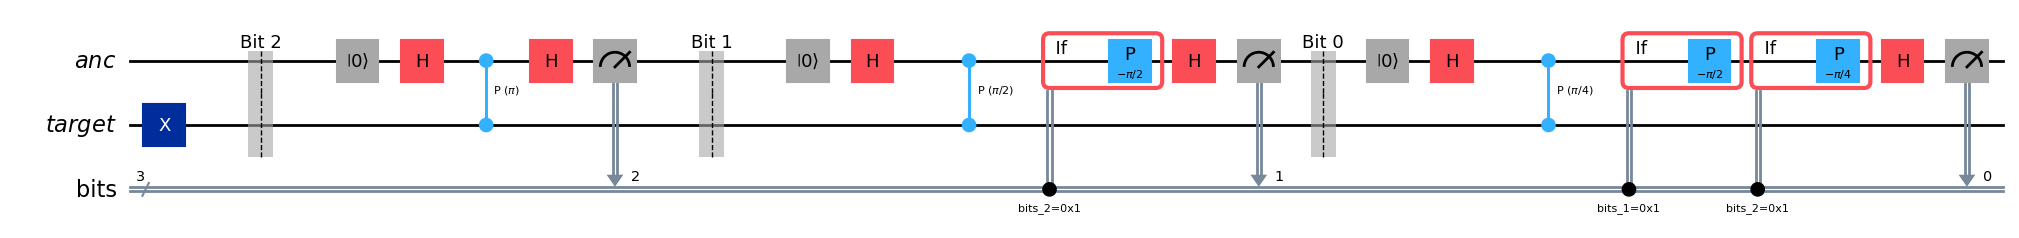

In [20]:
# Visualizza IQPE
iqpe_circuit.draw('mpl', fold=80)

In [21]:
def run_iqpe_simulation(circuit: QuantumCircuit, shots: int = 4096) -> dict:
    """Esegue IQPE (richiede supporto dynamic circuits)."""
    simulator = AerSimulator()
    sampler = AerSampler()
    
    job = sampler.run([circuit], shots=shots)
    counts = job.result()[0].data.bits.get_counts()
    
    return {'counts': counts}

# Esegui IQPE
print("Esecuzione IQPE per T-gate...\n")
iqpe_results = run_iqpe_simulation(iqpe_circuit, shots=4096)
analyze_qpe_results(iqpe_results['counts'], n_bits_iqpe, true_phase=0.125)

Esecuzione IQPE per T-gate...

════════════════════════════════════════════════════════════
ANALISI RISULTATI QPE
════════════════════════════════════════════════════════════

Binario      Decimale   Fase φ       Conteggi   Prob    
------------------------------------------------------------
100          4          0.500000     4096       1.0000   ← BEST

────────────────────────────────────────────────────────────
Fase stimata (modo): 0.500000
Fase vera: 0.125000
Errore assoluto: 0.375000
Errore relativo: 300.00%


(0.5, 1.0)

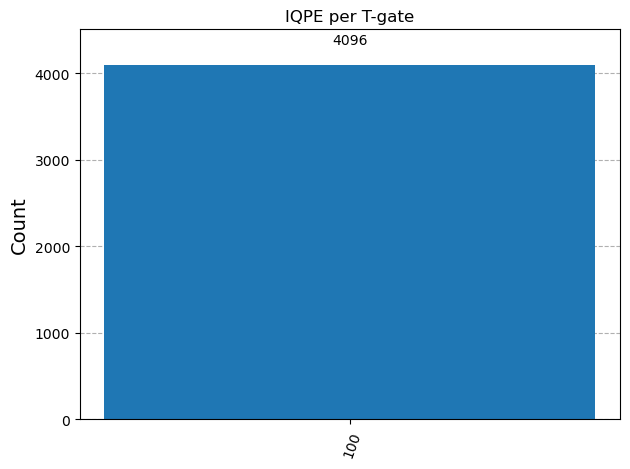

In [22]:
plot_histogram(iqpe_results['counts'], title='IQPE per T-gate')

### 6.3 IQPE con Feedback Classico Esplicito

Per backend senza dynamic circuits, eseguiamo le iterazioni separatamente.

In [23]:
def run_iqpe_classical(n_bits: int, phase_angle: float,
                       shots_per_bit: int = 1000) -> dict:
    """
    IQPE con feedback classico esplicito.
    
    Esegue ogni iterazione separatamente, funziona su qualsiasi backend.
    
    Args:
        n_bits: Bit di precisione
        phase_angle: Angolo θ
        shots_per_bit: Shots per iterazione
    
    Returns:
        Fase stimata e statistiche
    """
    simulator = AerSimulator()
    sampler = AerSampler()
    
    measured_bits = []  # Dal più significativo
    bit_probs = []
    
    print(f"{'Iter':<8} {'k':<5} {'Bit':<8} {'P(0)':<10} {'P(1)':<10}")
    print("-" * 45)
    
    for iteration, k in enumerate(range(n_bits - 1, -1, -1)):
        # Costruisci circuito per questa iterazione
        anc = QuantumRegister(1, 'anc')
        tgt = QuantumRegister(1, 'tgt')
        c = ClassicalRegister(1, 'c')
        qc = QuantumCircuit(anc, tgt, c)
        
        # Preparazione
        qc.x(tgt[0])  # |1⟩
        qc.h(anc)
        
        # Controlled-P^(2^k)
        qc.cp(phase_angle * (2**k), anc[0], tgt[0])
        
        # Correzione fase
        for j, bit_val in enumerate(measured_bits):
            if bit_val == 1:
                bit_pos = n_bits - 1 - j
                correction = -np.pi / (2 ** (bit_pos - k))
                qc.p(correction, anc)
        
        # Misura
        qc.h(anc)
        qc.measure(anc, c)
        
        # Esegui
        pm = generate_preset_pass_manager(optimization_level=1, backend=simulator)
        transpiled = pm.run(qc)
        job = sampler.run([transpiled], shots=shots_per_bit)
        counts = job.result()[0].data.c.get_counts()
        
        # Determina bit
        total = sum(counts.values())
        p0 = counts.get('0', 0) / total
        p1 = counts.get('1', 0) / total
        
        bit = 1 if p1 > p0 else 0
        measured_bits.append(bit)
        bit_probs.append(max(p0, p1))
        
        print(f"{iteration:<8} {k:<5} {bit:<8} {p0:<10.4f} {p1:<10.4f}")
    
    # Ricostruisci fase
    binary = ''.join(str(b) for b in measured_bits)
    decimal = int(binary, 2)
    phase = decimal / (2 ** n_bits)
    
    print("-" * 45)
    print(f"Binario: {binary}")
    print(f"Fase: {phase:.6f}")
    print(f"Confidenza media: {np.mean(bit_probs):.4f}")
    
    return {'phase': phase, 'binary': binary, 'confidence': np.mean(bit_probs)}

In [24]:
# Test IQPE classico
print("IQPE con Feedback Classico")
print("=" * 45)
print(f"Target: φ = 1/8 = 0.125\n")

iqpe_classic = run_iqpe_classical(3, np.pi/4, shots_per_bit=1000)
print(f"\nErrore: {abs(iqpe_classic['phase'] - 0.125):.6f}")

IQPE con Feedback Classico
Target: φ = 1/8 = 0.125

Iter     k     Bit      P(0)       P(1)      
---------------------------------------------
0        2     1        0.0000     1.0000    
1        1     0        1.0000     0.0000    
2        0     0        1.0000     0.0000    
---------------------------------------------
Binario: 100
Fase: 0.500000
Confidenza media: 1.0000

Errore: 0.375000


<a id='comparison'></a>
## 7. ⚖️ Confronto QPE vs IQPE

In [25]:
# Confronto risorse
print("═" * 70)
print("CONFRONTO RISORSE: QPE vs IQPE")
print("═" * 70)

data = []
for n in [3, 4, 5, 6]:
    qpe = build_qpe_circuit(n, np.pi/4)
    iqpe = build_iqpe_circuit(n, np.pi/4)
    
    data.append({
        'n': n,
        'qpe_q': qpe.num_qubits,
        'iqpe_q': iqpe.num_qubits,
        'qpe_d': qpe.depth(),
        'iqpe_d': iqpe.depth(),
    })

print(f"\n{'Bit':<6} {'QPE Qubit':<12} {'IQPE Qubit':<12} {'QPE Depth':<12} {'IQPE Depth':<12}")
print("-" * 55)
for d in data:
    print(f"{d['n']:<6} {d['qpe_q']:<12} {d['iqpe_q']:<12} {d['qpe_d']:<12} {d['iqpe_d']:<12}")

══════════════════════════════════════════════════════════════════════
CONFRONTO RISORSE: QPE vs IQPE
══════════════════════════════════════════════════════════════════════

Bit    QPE Qubit    IQPE Qubit   QPE Depth    IQPE Depth  
-------------------------------------------------------
3      4            2            12           19          
4      5            2            15           27          
5      6            2            18           36          
6      7            2            21           46          


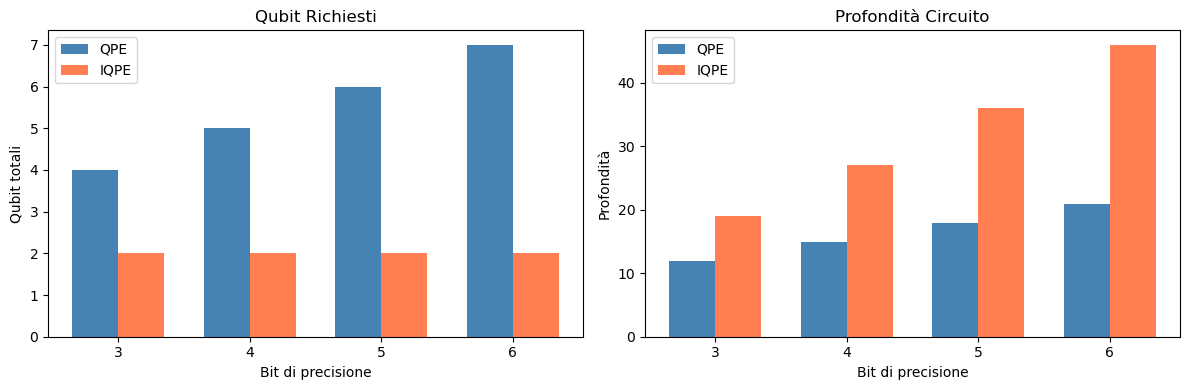

In [26]:
# Grafico comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ns = [d['n'] for d in data]
x = np.arange(len(ns))
w = 0.35

ax1.bar(x - w/2, [d['qpe_q'] for d in data], w, label='QPE', color='steelblue')
ax1.bar(x + w/2, [d['iqpe_q'] for d in data], w, label='IQPE', color='coral')
ax1.set_xlabel('Bit di precisione')
ax1.set_ylabel('Qubit totali')
ax1.set_title('Qubit Richiesti')
ax1.set_xticks(x)
ax1.set_xticklabels(ns)
ax1.legend()

ax2.bar(x - w/2, [d['qpe_d'] for d in data], w, label='QPE', color='steelblue')
ax2.bar(x + w/2, [d['iqpe_d'] for d in data], w, label='IQPE', color='coral')
ax2.set_xlabel('Bit di precisione')
ax2.set_ylabel('Profondità')
ax2.set_title('Profondità Circuito')
ax2.set_xticks(x)
ax2.set_xticklabels(ns)
ax2.legend()

plt.tight_layout()
plt.show()

### Riepilogo Vantaggi/Svantaggi

| Aspetto | QPE Standard | IQPE |
|---------|--------------|------|
| Qubit ancilla | n | 1 |
| Profondità | Alta | Media |
| Misure | 1 finale | n intermedie |
| Dynamic circuits | No | Sì |
| Robustezza rumore | Bassa | Migliore |
| Parallelismo | Alto | Sequenziale |

<a id='errors'></a>
## 8. 📊 Analisi degli Errori

In [27]:
print("═" * 65)
print("FONTI DI ERRORE IN QPE")
print("═" * 65)
print("""
1. DISCRETIZZAZIONE (intrinseco)
   Errore: Δφ = 1/2^(n+1)
   Soluzione: aumentare n

2. DECOERENZA (hardware)
   Causa: T1, T2 finiti
   Soluzione: circuiti corti, IQPE

3. ERRORI DI GATE (hardware)
   Gate 2q più rumorosi (~1% vs ~0.1%)
   Soluzione: ottimizzazione, error mitigation

4. ERRORI DI MISURA (hardware)
   Tipicamente 1-5%
   Soluzione: readout error mitigation
""")

═════════════════════════════════════════════════════════════════
FONTI DI ERRORE IN QPE
═════════════════════════════════════════════════════════════════

1. DISCRETIZZAZIONE (intrinseco)
   Errore: Δφ = 1/2^(n+1)
   Soluzione: aumentare n

2. DECOERENZA (hardware)
   Causa: T1, T2 finiti
   Soluzione: circuiti corti, IQPE

3. ERRORI DI GATE (hardware)
   Gate 2q più rumorosi (~1% vs ~0.1%)
   Soluzione: ottimizzazione, error mitigation

4. ERRORI DI MISURA (hardware)
   Tipicamente 1-5%
   Soluzione: readout error mitigation



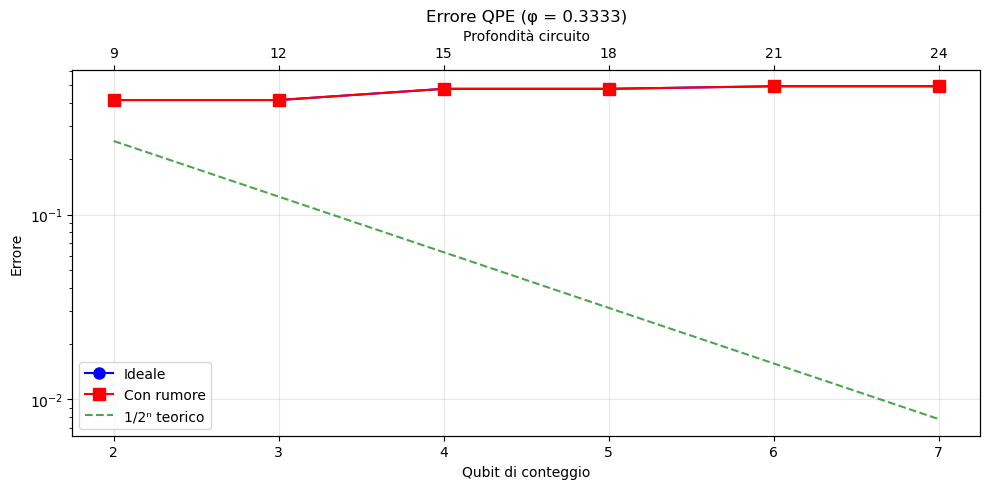


Osservazione: con rumore, oltre un certo punto aumentare n peggiora!


In [28]:
# Errore vs profondità con rumore
phi_true = 1/3
theta = 2 * np.pi * phi_true
noise = create_noise_model(p1q=0.0005, p2q=0.005)

ideal_errors = []
noisy_errors = []
depths = []

for n in range(2, 8):
    qpe = build_qpe_circuit(n, theta)
    depths.append(qpe.depth())
    
    # Ideale
    res_i = run_qpe_simulation(qpe, shots=2048)
    top_i = max(res_i['counts'].items(), key=lambda x: x[1])
    ph_i = int(top_i[0], 2) / (2**n)
    ideal_errors.append(abs(ph_i - phi_true))
    
    # Rumoroso
    res_n = run_qpe_noisy(qpe, noise, shots=2048)
    top_n = max(res_n['counts'].items(), key=lambda x: x[1])
    ph_n = int(top_n[0], 2) / (2**n)
    noisy_errors.append(abs(ph_n - phi_true))

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ns = list(range(2, 8))
ax.semilogy(ns, ideal_errors, 'bo-', label='Ideale', ms=8)
ax.semilogy(ns, noisy_errors, 'rs-', label='Con rumore', ms=8)
ax.semilogy(ns, [1/(2**n) for n in ns], 'g--', label='1/2ⁿ teorico', alpha=0.7)

ax.set_xlabel('Qubit di conteggio')
ax.set_ylabel('Errore')
ax.set_title(f'Errore QPE (φ = {phi_true:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ns)
ax2.set_xticklabels(depths)
ax2.set_xlabel('Profondità circuito')

plt.tight_layout()
plt.show()

print("\nOsservazione: con rumore, oltre un certo punto aumentare n peggiora!")

<a id='exercises'></a>
## 9. 🎓 Esercizi

### Esercizio 1: S-gate (Facile)
Stima la fase dell'S-gate ($\theta = \pi/2$, $\varphi = 1/4$).

### Esercizio 2: Precisione (Medio)
Quanti qubit servono per stimare $\varphi = \sqrt{2}/4$ con errore < 0.01?

### Esercizio 3: Robustezza (Avanzato)
Confronta QPE e IQPE variando il rumore. Trova il crossover point.

In [ ]:
# Spazio esercizi

# Es 1: S-gate
# qpe_s = build_qpe_circuit(3, np.pi/2)
# ...

# Es 2: sqrt(2)/4
# phi = np.sqrt(2)/4
# ...

<a id='references'></a>
## 10. 📖 Riferimenti

1. **Kitaev** (1995). *Quantum measurements and the Abelian Stabilizer Problem*. arXiv:quant-ph/9511026

2. **Nielsen & Chuang** (2000). *Quantum Computation and Quantum Information*. Section 5.2

3. **Dobšíček et al.** (2007). *Arbitrary accuracy iterative QPE*. Phys. Rev. A 76, 030306(R)

4. [Qiskit Textbook - QPE](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation)

---

**Course**: Quantum Computing Laboratory  
**License**: MIT  
**Version**: 2.2.0 (con Gate Parametrici Nativi + IQPE)  
**Last Updated**: December 2025